In [408]:
from typing import Dict, List, Optional, Tuple
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import torch
from torch import Tensor
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD, Optimizer, Adam
from pytorch_lightning import Trainer
from scipy.stats import multivariate_normal, sem
from sklearn.linear_model import BayesianRidge
from pytorch_lightning import LightningModule

from experiments.linear_regression_posterior import compute_true_posterior
from experiments.utils.metrics import compute_distance_between_matrices, compute_gaussian_wasserstein_distance
from swafa.models import FeedForwardNet
from swafa.callbacks import FactorAnalysisVariationalInferenceCallback

np.set_printoptions(suppress=True) # don't use scientific notation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define helper functions and classes

In [419]:
class GaussianNet(LightningModule):

    def __init__(self, dataset_size: int, input_dim: int, 
                 hidden_dims: Optional[List[int]] = None,
                 hidden_activation_fn: Optional[nn.Module] = None, bias: bool = True, 
                 optimiser_class: Optimizer = Adam, 
                 optimiser_kwargs: Optional[dict] = None,
                 target_variance: float = None, random_seed: Optional[int] = None):
        
        super().__init__()
        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.dataset_size = dataset_size
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims or []
        self.hidden_activation_fn = hidden_activation_fn or self._identity_fn
        self.optimiser_class = optimiser_class
        self.optimiser_kwargs = optimiser_kwargs or dict(lr=1e-3)
        self.loss_fn = nn.GaussianNLLLoss(reduction='mean')
        self.target_variance = target_variance or 1.0

        self.hidden_layers = nn.ModuleList()
        d_in = deepcopy(input_dim)
        for d_out in self.hidden_dims:
            self.hidden_layers.append(nn.Linear(d_in, d_out, bias=bias))
            d_in = d_out

        self.mu_layer = nn.Linear(d_in, 1, bias=bias)

    @staticmethod
    def _identity_fn(X: Tensor) -> Tensor:
        return X

    def forward(self, X: Tensor) -> Tensor:
        for layer in self.hidden_layers:
            X = self.hidden_activation_fn(layer(X))

        mu = self.mu_layer(X).squeeze(dim=1)
        var = torch.ones_like(mu) * self.target_variance
        
        return mu, var

    def configure_optimizers(self) -> Optimizer:
        return self.optimiser_class(self.parameters(), **self.optimiser_kwargs)

    def training_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        return self._step(batch, batch_idx)

    def validation_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        return self._step(batch, batch_idx)

    def test_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        return self._step(batch, batch_idx)

    def _step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        X, y = batch
        mu, var = self(X)
        return self.loss_fn(mu, y, var) * self.dataset_size

    def validation_epoch_end(self, step_losses: List[Tensor]) -> Dict[str, Tensor]:
        loss = self._average_loss(step_losses)
        metrics = dict(epoch_val_loss=loss)
        self.log_dict(metrics)
        return metrics

    def test_epoch_end(self, step_losses: List[Tensor]) -> Dict[str, Tensor]:
        loss = self._average_loss(step_losses)
        metrics = dict(epoch_test_loss=loss)
        self.log_dict(metrics)
        return metrics

    @staticmethod
    def _average_loss(step_losses: List[Tensor]) -> Tensor:
        return torch.stack(step_losses).mean()


def run_experiment(n_samples: int, n_features: int, feature_covar: np.ndarray, alpha: float, beta: float, 
                   latent_dim: int, n_gradients_per_update: int, optimiser_class: Optimizer,
                   bias_optimiser_kwargs: dict, factors_optimiser_kwargs: dict, noise_optimiser_kwargs: int,
                   n_epochs: int, batch_size: int, max_grad_norm: float, n_trials: int,
                  ) -> (List[float], List[float], List[float]):
    
    relative_distances_from_mean = []
    relative_distances_from_cov = []
    wasserstein_distances = []
    for n in range(n_trials):
        true_posterior_mean, true_posterior_covar, variational_mean, variational_covar = run_trial(
            n_samples=n_samples, 
            n_features=n_features, 
            feature_covar=feature_covar, 
            alpha=alpha, 
            beta=beta, 
            latent_dim=latent_dim, 
            n_gradients_per_update=n_gradients_per_update,
            optimiser_class=optimiser_class,
            bias_optimiser_kwargs=bias_optimiser_kwargs,
            factors_optimiser_kwargs=factors_optimiser_kwargs,
            noise_optimiser_kwargs=noise_optimiser_kwargs,
            n_epochs=n_epochs,
            batch_size=batch_size, 
            max_grad_norm=max_grad_norm,
            random_seed=n
        )
        
        relative_distances_from_mean.append(
            compute_distance_between_matrices(
                true_posterior_mean, 
                variational_mean,
            ) /
            compute_distance_between_matrices(
                true_posterior_mean, 
                torch.zeros_like(true_posterior_mean),
            )
        )
        
        relative_distances_from_cov.append(
            compute_distance_between_matrices(
                true_posterior_covar, 
                variational_covar,
            ) /
            compute_distance_between_matrices(
                true_posterior_covar, 
                torch.zeros_like(true_posterior_covar),
            )
        )
        
        wasserstein_distances.append(
            compute_gaussian_wasserstein_distance(
                mean1=true_posterior_mean, 
                covar1=true_posterior_covar, 
                mean2=variational_mean, 
                covar2=variational_covar,
            )
        )
        
    return relative_distances_from_mean, relative_distances_from_cov, wasserstein_distances


def run_trial(n_samples: int, n_features: int, feature_covar: np.ndarray, alpha: float, beta: float, 
              latent_dim: int, n_gradients_per_update: int, optimiser_class: Optimizer,
              bias_optimiser_kwargs: dict, factors_optimiser_kwargs: dict, noise_optimiser_kwargs: int,
              n_epochs: int, batch_size: int, max_grad_norm: float, random_seed: int,
             ) -> (Tensor, Tensor, Tensor, Tensor, FactorAnalysisVariationalInferenceCallback):
    
    X, y = generate_data(n_samples, n_features, feature_covar, beta, random_seed)
    
    true_posterior_mean, true_posterior_covar, _, _ = compute_true_posterior(
        X, y, alpha=alpha, beta=beta
    )
    
    model = GaussianNet(
        dataset_size=n_samples,
        input_dim=n_features, 
        bias=False, 
        optimiser_class=optimiser_class, 
        optimiser_kwargs=bias_optimiser_kwargs,
        target_variance=1 / beta,
    )
    
    callback = FactorAnalysisVariationalInferenceCallback(
        latent_dim, 
        precision=alpha, 
        n_gradients_per_update=n_gradients_per_update, 
        optimiser_class=optimiser_class, 
        bias_optimiser_kwargs=bias_optimiser_kwargs,
        factors_optimiser_kwargs=factors_optimiser_kwargs,
        noise_optimiser_kwargs=noise_optimiser_kwargs,
        max_grad_norm=max_grad_norm,
        random_seed=random_seed,
    )
    
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)

    trainer = Trainer(
        max_epochs=n_epochs, callbacks=callback, progress_bar_refresh_rate=0,
    )
    trainer.fit(model, train_dataloader=dataloader)
    
    variational_mean = callback.get_variational_mean()
    variational_covar = callback.get_variational_covariance()
    
    return true_posterior_mean, true_posterior_covar, variational_mean, variational_covar

    
def generate_data(n_samples: int, n_features: int, feature_covar: np.ndarray, beta: float, random_seed: int,
                  ) -> (np.ndarray, np.ndarray):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    p_x = MultivariateNormal(loc=torch.zeros(n_features), covariance_matrix=torch.Tensor(feature_covar))
    X = p_x.sample((n_samples,))

    p_theta = MultivariateNormal(loc=torch.zeros(n_features), covariance_matrix=torch.eye(n_features) / alpha)
    theta = p_theta.sample().reshape(-1, 1)

    epsilon = torch.normal(torch.zeros(n_samples), (1 / np.sqrt(beta)) * torch.ones(n_samples))
    y = X.mm(theta).squeeze() + epsilon
    
    return X, y

### Define parameters

In [409]:
# data
n_samples, n_features = 1000, 2
feature_covar = [
    [1, 0.5], 
    [0.5, 1]
]
alpha = 0.01
beta = 0.1

# callbacks
latent_dim = 2
n_gradients_per_update = 10
optimiser_class = SGD
bias_optimiser_kwargs = dict(lr=1e-2)
factors_optimiser_kwargs = dict(lr=1e-4)
noise_optimiser_kwargs = dict(lr=1e-2)

# training
batch_size = 100
n_epochs = 5000
max_grad_norm = 10

### Run experiment with multiple trials

In [420]:
relative_distances_from_mean, relative_distances_from_cov, wasserstein_distances = run_experiment(
    n_samples=n_samples, 
    n_features=n_features, 
    feature_covar=feature_covar, 
    alpha=alpha, 
    beta=beta, 
    latent_dim=latent_dim, 
    n_gradients_per_update=n_gradients_per_update,
    optimiser_class=optimiser_class,
    bias_optimiser_kwargs=bias_optimiser_kwargs,
    factors_optimiser_kwargs=factors_optimiser_kwargs,
    noise_optimiser_kwargs=noise_optimiser_kwargs,
    n_epochs=n_epochs,
    batch_size=batch_size,
    max_grad_norm=max_grad_norm,
    n_trials=10
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type            | Params
--------------------------------------------------
0 | loss_fn       | GaussianNLLLoss | 0     
1 | hidden_layers | ModuleList      | 0     
2 | mu_layer      | Linear          | 2     
--------------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type            | Params
--------------------------------------------------
0 | loss_fn       | GaussianNLLLoss | 0     
1 | hidden_layers | ModuleList      | 0     
2 | mu_layer      | Linear          | 2     
--------------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
GPU available: False, us

In [421]:
relative_distances_from_mean_mean = np.mean(relative_distances_from_mean)
relative_distances_from_mean_std_error = sem(relative_distances_from_mean)

relative_distances_from_cov_mean = np.mean(relative_distances_from_cov)
relative_distances_from_cov_std_error = sem(relative_distances_from_cov)

wasserstein_mean = np.mean(wasserstein_distances)
wasserstein_std_error = sem(wasserstein_distances)

print('Mean Relative Distance from Mean = {:.4f} +- {:.4f}'.format(
    relative_distances_from_mean_mean, relative_distances_from_mean_std_error,
))

print('Mean Relative Distance from Covar = {:.4f} +- {:.4f}'.format(
    relative_distances_from_cov_mean, relative_distances_from_cov_std_error,
))

print('Mean Wasserstein Distance = {:.4f} +- {:.4f}'.format(
    wasserstein_mean, wasserstein_std_error,
))

Mean Relative Distance from Mean = 0.0040 +- 0.0008
Mean Relative Distance from Covar = 0.1053 +- 0.0199
Mean Wasserstein Distance = 0.0027 +- 0.0006


### Plot distributions for a single trial

In [422]:
true_posterior_mean, true_posterior_covar, variational_mean, variational_covar = run_trial(
    n_samples=n_samples, 
    n_features=n_features, 
    feature_covar=feature_covar, 
    alpha=alpha, 
    beta=beta, 
    latent_dim=latent_dim, 
    n_gradients_per_update=n_gradients_per_update,
    optimiser_class=optimiser_class,
    bias_optimiser_kwargs=bias_optimiser_kwargs,
    factors_optimiser_kwargs=factors_optimiser_kwargs,
    noise_optimiser_kwargs=noise_optimiser_kwargs,
    n_epochs=n_epochs,
    batch_size=batch_size, 
    max_grad_norm=max_grad_norm,
    random_seed=0
)


true_posterior_mean = true_posterior_mean.numpy()
true_posterior_covar = true_posterior_covar.numpy()
variational_mean = variational_mean.numpy()
variational_covar = variational_covar.numpy()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type            | Params
--------------------------------------------------
0 | loss_fn       | GaussianNLLLoss | 0     
1 | hidden_layers | ModuleList      | 0     
2 | mu_layer      | Linear          | 2     
--------------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


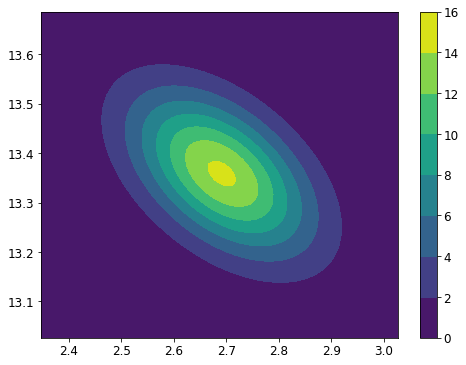

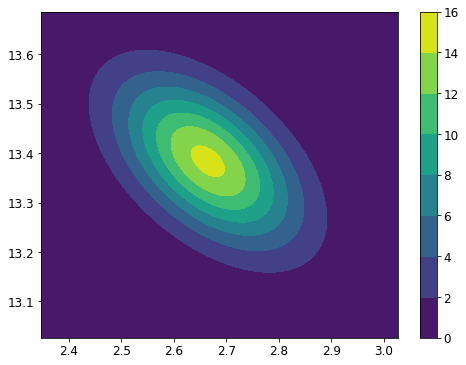

In [424]:
def plot_pdf(mean: np.ndarray, covar: np.ndarray, ax: Axes, x_grid: np.ndarray = None, y_grid: np.ndarray = None):
    plt.rcParams.update({'font.size': 12})
    
    if x_grid is None:
        x_std3 = np.sqrt(covar[0, 0]) * 3
        x_min = mean[0] - x_std3
        x_max = mean[0] + x_std3

        y_std3 = np.sqrt(covar[1, 1]) * 3
        y_min = mean[1] - y_std3
        y_max = mean[1] + y_std3

        x_grid, y_grid = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
        
    pos = np.dstack((x_grid, y_grid))
    rv = multivariate_normal(mean, covar)
    c = ax.contourf(x_grid, y_grid, rv.pdf(pos))
    plt.colorbar(c, ax=ax)
    
    return x_grid, y_grid
    

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
x_grid, y_grid = plot_pdf(true_posterior_mean, true_posterior_covar, axes)
png_path = f'../../thesis/plots/linear_model_true_posterior.png'
plt.savefig(png_path, format='png')
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
plot_pdf(variational_mean, variational_covar, axes, x_grid, y_grid)
png_path = f'../../thesis/plots/linear_model_vi_posterior__latent_dim={latent_dim}.png'
plt.savefig(png_path, format='png')
plt.show()